In [1]:
import tensorflow as tf
import numpy as np
import util
import matplotlib.pyplot as plt
import io
from PIL import Image
import os

from models.VAE import VEncoder, Decoder

In [2]:
Xtrain, Ytrain, Xtest, Ytest = util.getKaggleMNIST()

In [3]:
Xtrain.shape

(41000, 784)

In [13]:
net = [200,100,2]
input_dims = 784
encoder_layer = VEncoder(net)
decoder_layer = Decoder(net[::-1] + [input_dims])
net[::-1] + [input_dims]

[2, 100, 200, 784]

In [14]:
inputs = tf.keras.layers.Input(shape=(input_dims,), name='encoder_input')
z_mean, z_log_var, z = encoder_layer(inputs)
encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
v_encoder_5 (VEncoder)       [(None, 2), (None, 2), (N 177504    
Total params: 177,504
Trainable params: 177,504
Non-trainable params: 0
_________________________________________________________________


In [15]:
deco_inputs = tf.keras.layers.Input(shape=(net[-1],), name='decoder_input')
decoder = tf.keras.models.Model(deco_inputs, decoder_layer(deco_inputs), name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
decoder_5 (Decoder)          (None, 784)               178090    
Total params: 178,090
Trainable params: 178,090
Non-trainable params: 0
_________________________________________________________________


In [22]:
# instantiate VAE model
outputs = decoder(encoder_layer(inputs)[2])
vae = tf.keras.models.Model(inputs, outputs, name='vae_mlp')

In [23]:
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= input_dims

kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
v_encoder_5 (VEncoder)       [(None, 2), (None, 2), (N 177504    
_________________________________________________________________
decoder (Model)              (None, 784)               178090    
Total params: 355,594
Trainable params: 355,594
Non-trainable params: 0
_________________________________________________________________


In [24]:
summaries_dir = "summaries/vae0_mnist"
tf.gfile.DeleteRecursively(summaries_dir) if tf.gfile.Exists(summaries_dir) else None
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=summaries_dir)

In [25]:
vae.fit(
    x=Xtrain,
    batch_size=32,
    epochs=10,
    verbose=1,
    shuffle=True,
    validation_data=(Xtest, None),
    callbacks=[
        tensorboard_callback,
    ]
)

Train on 41000 samples, validate on 1000 samples
Epoch 1/10
41000/41000 [==============================] - 6s 157us/sample - loss: 143.5936 - val_loss: 144.6063
Epoch 2/10
41000/41000 [==============================] - 6s 147us/sample - loss: 143.9133 - val_loss: 143.8580
Epoch 3/10
41000/41000 [==============================] - 6s 144us/sample - loss: 143.4834 - val_loss: 144.8778
Epoch 4/10
41000/41000 [==============================] - 6s 144us/sample - loss: 143.2046 - val_loss: 144.6910
Epoch 5/10
41000/41000 [==============================] - 6s 144us/sample - loss: 143.1784 - val_loss: 145.2814
Epoch 6/10
41000/41000 [==============================] - 6s 149us/sample - loss: 142.8217 - val_loss: 143.0447
Epoch 7/10
41000/41000 [==============================] - 6s 147us/sample - loss: 142.5559 - val_loss: 144.1746
Epoch 8/10
41000/41000 [==============================] - 6s 150us/sample - loss: 142.2666 - val_loss: 143.7488
Epoch 9/10
41000/41000 [==============================]

In [20]:
def plot_results(models, data, batch_size=128, model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

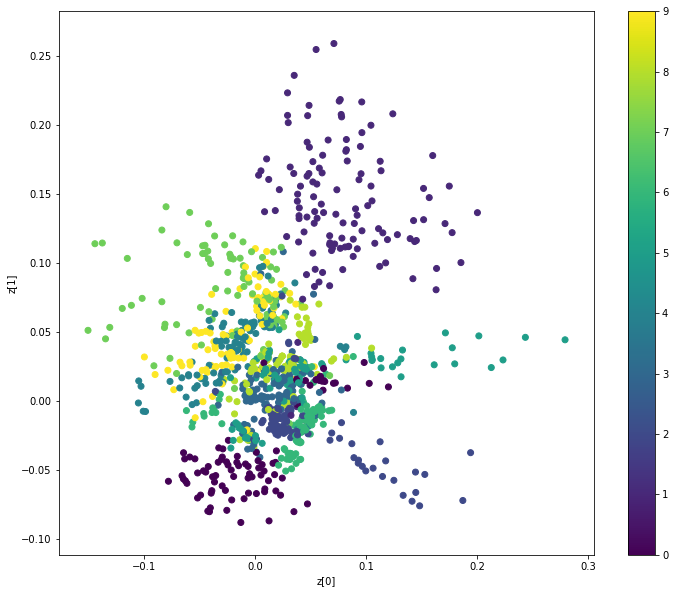

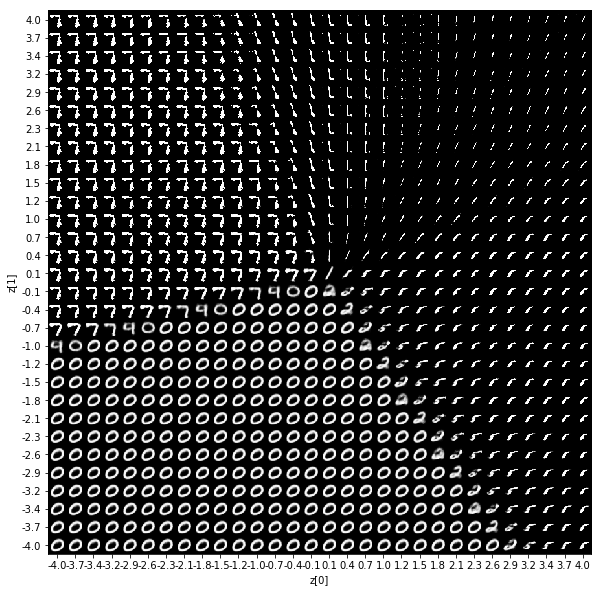

In [26]:
models = (encoder, decoder)
data = (Xtest, Ytest)
plot_results(models, data)